## Load Contextual Plus Streams and do text searches

In [267]:
import os, sys, gzip, json, pprint, pymongo, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [93]:
EVENTS = {
#     'harvey'      : '/data/chime/Hurricanes_HIM/contextual-plus/OfficialSources_HIM/GNIP/', #HarveyIrma CP
#     'matthew'     : '/data/chime/matthew/gnip/',              # This is all keyword collection from Matthew
#     'matthew-geo' : '/data/chime/matthew/gnip-geo/all/' # This is all tweets from within the windswath of Matthew
    'harvey_kw' : '/data/chime/Hurricanes_HIM/keyword/harvey/GNIP/',
    'sandy'  : '/data/chime/sandy_tweets_gnip_simple.jsonl'
}

START_DATES = {
    'sandy': datetime(2012,10,22,0,0,0),
    'harvey_kw': datetime(2017,8,17,0,0,0)
}

END_DATES = {
    'sandy': datetime(2012,10,31,0,0,0),
    'harvey_kw': datetime(2017,8,27,0,0,0)
}

In [94]:
def simplify_tweet(t):
    '''Simplify tweet to only specified attributes (e.g. id, text, date, user attributes, etc.)'''
    new_tweet = {'id':t['id'].split(':')[2],
                 'text':t['body'].replace("\n"," ").replace("\r"," ").replace("\t"," "),
                 'created_at':datetime.strptime(t['postedTime'], "%Y-%m-%dT%H:%M:%S.%fZ"),
                 'user':t['actor']['preferredUsername'].replace("\t"," "),
                 'verb':t['verb']
                }        
    return(new_tweet)

In [95]:
def gzip_to_full_tweet(file, event):
    tweets          = []
    tweet_count     = 0
    error_count     = 0
    info = None
    rt_count = 0
    
    with gzip.open(file, 'rb') as f:
        file_content = f.read()
        
        for idx, line in enumerate(file_content.decode().split("\n")):
            tweet_count += 1
            try:
                t = json.loads(line.strip())
            except json.JSONDecodeError:
                if(line==""):
                    pass
                
            if 'info' in t:
                info = t
            else:
                if t['verb'] != 'share':
                    t = simplify_tweet(t)
                    if t['created_at'] > START_DATES[event] and t['created_at'] < END_DATES[event]:
                        tweets.append(t)
                else:
                    rt_count+=1

            if idx%1000==0:
                sys.stderr.write("\r{0} tweets parsed      ".format(tweet_count))
#     sys.stderr.write("\r{0} tweets parsed     ".format(tweet_count))
    return tweets, info, rt_count

In [113]:
def load_jsonl(file):
    t_count = 0
    rt_count = 0
    tweet_array = []

    with open(file,'r') as inFile:
        for line in inFile:
            t = json.loads(line)
            if t['verb'] != 'share':
                t['created_at'] = datetime.strptime(t['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
                tweet_array.append(t)
                t_count += 1
                if t_count%10000==0:
                    sys.stderr.write("\r"+" Loaded {0} tweets, skipped {1} retweets".format(t_count, rt_count))
            else: 
                rt_count += 1
    return tweet_array

In [114]:
def get_tweets(event, limit=None):
    gnip_files = os.listdir( EVENTS[event] )
    print("Found {0} GNIP files, limit: {1}".format(len(gnip_files), limit))
    
    t_count = 0
    rt_count_total = 0
    tweet_array = []
    for idx, file in enumerate(gnip_files[:limit]):
        parts = file.split("_")
        file_date = datetime(int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4]), int(parts[5]),0)
        if file_date < START_DATES[event] or file_date > END_DATES[event]:
            continue
        
        tweets, info, rt_count = gzip_to_full_tweet(EVENTS[event] +file, event)
        t_count += info['info']['activity_count']
        tweet_array += tweets
        rt_count_total += rt_count
        if idx%2==0:
            sys.stderr.write("\r"+" "*80 + "{0} files; {1} tweets".format(idx+1, t_count))
    print("{0} files processed with {1} tweets, skipped {2} retweets".format(idx+1, t_count, rt_count_total))
    return tweet_array

# Step 1: Load Tweets

### Sandy Keyword Tweets

In [115]:
sandy_tweets = load_jsonl(EVENTS['sandy'])

 Loaded 4840000 tweets, skipped 4175875 retweets

In [ ]:
SANDY = pd.DataFrame(sandy_tweets)
SANDY['date'] = SANDY.created_at.apply(lambda x: x.date())
print("Tweets: {0}".format(len(SANDY)))
SANDY.head()

Tweets: 4847095


,created_at,id,text,user,verb,date
0,2012-10-24 23:58:06,261255274801815552,New 8PM update from the National Hurricane Cen...,MikeMasco,post,2012-10-24
1,2012-10-24 23:58:07,261255282758402048,Prayers over Jamaica.As Hurricane Sandy approa...,KaiyaNichole,post,2012-10-24
2,2012-10-24 23:58:07,261255281726603266,That T.S turned into a Hurricane in A Few hour...,DJ_BMONEY,post,2012-10-24
3,2012-10-24 23:58:09,261255287581843457,All the news of Hurricane Sandy has left Sandy...,littleritzz,post,2012-10-24
4,2012-10-24 23:58:14,261255312147881985,@mooremayhem IS A YAAD TING when we get RASS ...,WiggiLeaks,post,2012-10-24


### Harvey Keyword Tweets

In [ ]:
harvey_tweets = get_tweets('harvey_kw')

Found 3456 GNIP files, limit: None


3001 tweets parsed                                                              1905 files; 3149587 tweets

In [ ]:
HARVEY = pd.DataFrame(harvey_tweets)
HARVEY['date'] = HARVEY.created_at.apply(lambda x: x.date())
print("Tweets: {0}".format(len(HARVEY)))
HARVEY.head()

# Some DataFrame Analysis

In [ ]:
SANDY_WORDS  = ['flooded','sandy','evacuate','electricity','shelter','destroy','generators','light','power','emergency ','candles','flashlights','decisions','disaster','forecast','wind','repair','scary','heat','school ','worried ','response','hospital','rising','substations','government','meetings','population','resources','mayor','receding','relatives','supplies','leaders','looting','transportation','waves','fires','rain','abandoned','devastated','drowned','ocean','raised','rescue','safe','stuck','suffering','survivied','afraid','bridge','designated','impact','neighborhood','rebuild','scared','telephone','twitter','dangerous','federal','firefighters','floated','grid','risk','scientist','terrible','tornado','trouble','administration','announce','authorities','bags','bathtubs','batteries','dumping','fuel','pouring','residents','roof','ambulences','canal','coastal','death','died','donate','garbage','governer','infrastructure','facebook','media','paper','television','computer','cell','internet']
HARVEY_WORDS = ['water','helps','community','storm','call','prepared','hurricane','rains','stay','phone','talking','evacuate','homes','news','leave','rescue','tornado','boat','family','church','neighbor','media','fema','bayou','warnings','facebook','weather','emergency','lights','radio','plans','money','power','channel','wind','damage','forecast','decision','shelter','devastation','alerts','gulf','police','rita','cell','lake','seniors','rising','stuck','drain','electricity','drainage','governments','safe','decide','higher','officials','afraid','danger','katrina','mayor','rainfall','surge','trapped','deep','disabled','leaders','strong','bayous','blessed','hospital','praying','frustrating','mexican','risk','river','univision','generator','safety','tide','agency','disaster','faith','mandatory','medicine','reservoirs','hotel','levies','pets','stranded','underwater']

In [ ]:
SANDY['keywords']  = SANDY.text.apply(lambda text: pd.Series([x in text.lower() for x in SANDY_WORDS]).any())
HARVEY['keywords'] = HARVEY.text.apply(lambda text: pd.Series([x in text.lower() for x in HARVEY_WORDS]).any())

In [ ]:
SANDY.head()

In [ ]:
HARVEY.head()

### Secondary Search Words

In [275]:
SOCIAL_NETWORKS = ['help','mother','father','brother','sister','grandmother','grandfather','neighbor ','friend','community','church','school ','pastor','principal','kids','cousin','neice ','nephew','son ','daughter','aunt','uncle','teacher','neighborhood','children','manager','stuck','aid','assist','grandma','grandpa','family']
FORECAST_INFO   = ['flood','rain','surge','wind','water','cone','dirty side','clean side','uncertainty','intensify','landfall','category','forecast','pressure','hurricane','trajectory','tropical','disturbance','depression','tv','radio','internet','paper']
PROTECTIVE_DECISIONS = ['stay','leave','shelter','ride','evacuate','roof','higher','attic','get out','rob','theives','pet','dog','cat','motel','hotel','traffic','highway','road','vacancy','go','shutters','elevator','power','electricity','order','mayor','car','subway','bus','basement','last time','shelter']
MATERIAL_NEEDS = ['volunteer','cajun navy','boat','help','phone','cell','rescue','supplies ','canoe','kayak','food','meals','cooking','cash','money','generator','milk','bread','eggs','store','doctor','medicine','gas']
BEAUROCRATIC_ASSISTANCE = ['papers','fema','red cross','city','Super neighborhood','county','emergency manager','police','fire']

In [276]:
def second_level_search(df):
    df['SOCIAL_NETWORKS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in SOCIAL_NETWORKS]).any())
    df['FORECAST_INFO'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in FORECAST_INFO]).any())
    df['PROTECTIVE_DECISIONS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in PROTECTIVE_DECISIONS]).any())
    df['MATERIAL_NEEDS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in MATERIAL_NEEDS]).any())
    df['BEAUROCRATIC_ASSISTANCE'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in BEAUROCRATIC_ASSISTANCE]).any())    

In [277]:
second_level_search(SANDY)
second_level_search(HARVEY)

In [278]:
print(len(SANDY))
SANDY.head()

4847095


,created_at,id,text,user,verb,date,keywords,SOCIAL_NETWORKS,FORECAST_INFO,PROTECTIVE_DECISIONS,MATERIAL_NEEDS,BEAUROCRATIC_ASSISTANCE
0,2012-10-24 23:58:06,261255274801815552,New 8PM update from the National Hurricane Cen...,MikeMasco,post,2012-10-24,True,False,True,True,False,False
1,2012-10-24 23:58:07,261255282758402048,Prayers over Jamaica.As Hurricane Sandy approa...,KaiyaNichole,post,2012-10-24,True,True,True,False,False,False
2,2012-10-24 23:58:07,261255281726603266,That T.S turned into a Hurricane in A Few hour...,DJ_BMONEY,post,2012-10-24,False,False,True,False,False,False
3,2012-10-24 23:58:09,261255287581843457,All the news of Hurricane Sandy has left Sandy...,littleritzz,post,2012-10-24,True,True,True,False,False,False
4,2012-10-24 23:58:14,261255312147881985,@mooremayhem IS A YAAD TING when we get RASS ...,WiggiLeaks,post,2012-10-24,True,True,True,True,False,False


In [279]:
print(len(HARVEY))
HARVEY.head()

1416755


,created_at,id,text,user,verb,date,keywords,SOCIAL_NETWORKS,FORECAST_INFO,PROTECTIVE_DECISIONS,MATERIAL_NEEDS,BEAUROCRATIC_ASSISTANCE
0,2017-08-23 18:00:00,900417352453373953,Sarah Harvey talks about Harvey Lawrence – whe...,harveylawrence,post,2017-08-23,False,False,False,True,False,False
1,2017-08-23 18:00:04,900417371080347650,"If you live along the Gulf Coast, stay safe an...",gacarol18,post,2017-08-23,True,False,False,True,False,False
2,2017-08-23 18:00:14,900417412117536768,New post (Harvey Could Become First Hurricane ...,kilocals,post,2017-08-23,True,False,True,False,False,False
3,2017-08-23 18:00:15,900417416911626240,Nike Mens Sportswear Pull Over Club Hooded Swe...,USA_OnlineDeals,post,2017-08-23,False,False,False,False,False,False
4,2017-08-23 18:00:59,900417598722121728,I'm pretty sure the mall will stay open during...,charityemmite,post,2017-08-23,True,False,True,True,True,False


<hr>
<br>
# 2. Group the dataframes by user 
Get counts for tweets within the second level filtering to identify users of most interest? 

In [280]:
HARVEY_gb_user = HARVEY.groupby('user')

In [281]:
SANDY_gb_user = SANDY.groupby('user')

In [282]:
def find_interesting_users(DF_gb_user, threshold=10):
    USERS_SN = []
    USERS_FI = []
    USERS_PD = []
    USERS_MN = []
    USERS_BA = []
    
    count = 0;

    for user, tweets in DF_gb_user:
    #     if tweets.keywords.any():
        if tweets.SOCIAL_NETWORKS.sum() > threshold:
            USERS_SN.append( (user, tweets.SOCIAL_NETWORKS.sum() ) )
        
        if tweets.FORECAST_INFO.sum() > threshold:
            USERS_FI.append( (user, tweets.FORECAST_INFO.sum() ) )
        
        if tweets.PROTECTIVE_DECISIONS.sum() > threshold:
            USERS_PD.append( (user, tweets.PROTECTIVE_DECISIONS.sum() ) )
        
        if tweets.MATERIAL_NEEDS.sum() > threshold:
            USERS_MN.append( (user, tweets.MATERIAL_NEEDS.sum() ) )
        
        if tweets.BEAUROCRATIC_ASSISTANCE.sum() > threshold:
            USERS_BA.append( (user, tweets.BEAUROCRATIC_ASSISTANCE.sum() ) )

        count+=1
        if count%100==0:
            sys.stderr.write("\r"+" Processed {0} users".format(count))

    return {
        'social_networks' : USERS_SN,
        'forecast_info' : USERS_FI,
        'protective_decisions' : USERS_PD,
        'material_needs' : USERS_MN,
        'beaurocratic_assistance' : USERS_BA
    }

In [283]:
harvey_users = find_interesting_users(HARVEY_gb_user)

 Processed 612800 users

In [284]:
sandy_users = find_interesting_users(SANDY_gb_user)

 Processed 2391200 users

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f546b48cf98>],
      dtype=object)

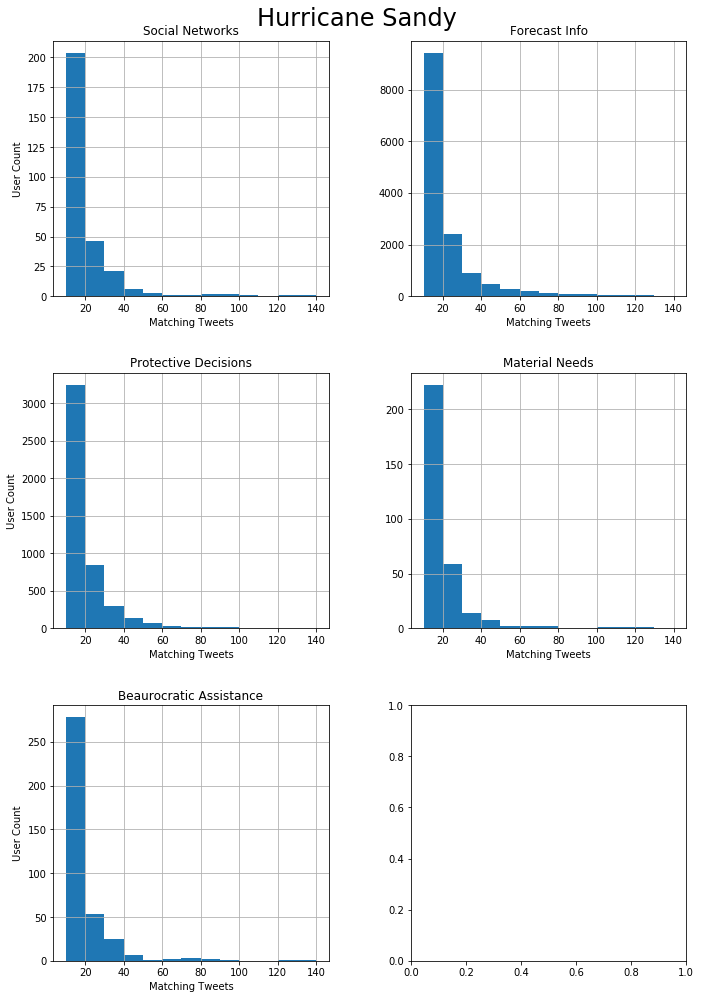

In [286]:
bins = np.arange(10,150,10)
figure, axes = plt.subplots(3, 2)
plt.tight_layout()
figure.set_figheight(15); figure.set_figwidth(10); plt.suptitle("Hurricane Sandy", fontsize=24)
axes[0,0].set_ylabel("User Count"); axes[0,0].set_xlabel("Matching Tweets"); axes[0,1].set_xlabel("Matching Tweets")
axes[1,0].set_ylabel("User Count"); axes[1,0].set_xlabel("Matching Tweets"); axes[1,1].set_xlabel("Matching Tweets")
axes[2,0].set_ylabel("User Count"); axes[2,0].set_xlabel("Matching Tweets");
pd.DataFrame({'Social Networks' : [x[1] for x in sandy_users['social_networks']]}).hist(ax=axes[0,0], bins=bins)
pd.DataFrame({'Forecast Info' : [x[1] for x in sandy_users['forecast_info']]}).hist(ax=axes[0,1], bins=bins)
pd.DataFrame({'Protective Decisions' : [x[1] for x in sandy_users['protective_decisions']]}).hist(ax=axes[1,0], bins=bins)
pd.DataFrame({'Material Needs' : [x[1] for x in sandy_users['material_needs']]}).hist(ax=axes[1,1], bins=bins)
pd.DataFrame({'Beaurocratic Assistance' : [x[1] for x in sandy_users['beaurocratic_assistance']]}).hist(ax=axes[2,0], bins=bins)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f542a692668>],
      dtype=object)

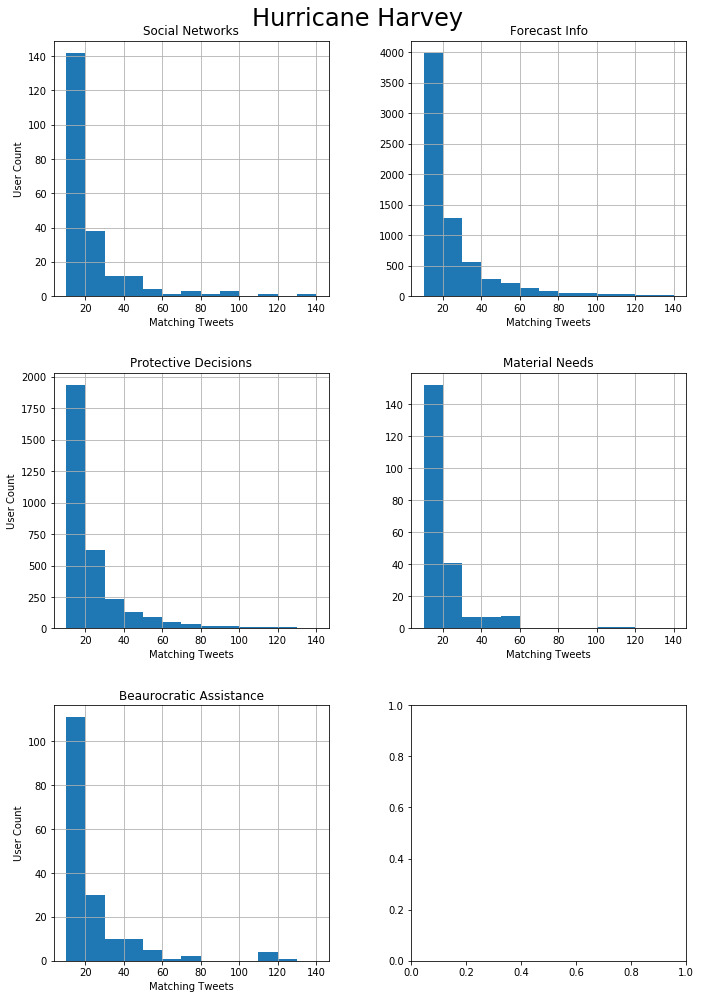

In [298]:
bins = np.arange(10,150,10)
figure, axes = plt.subplots(3, 2)
plt.tight_layout()
figure.set_figheight(15); figure.set_figwidth(10); plt.suptitle("Hurricane Harvey", fontsize=24)
axes[0,0].set_ylabel("User Count"); axes[0,0].set_xlabel("Matching Tweets"); axes[0,1].set_xlabel("Matching Tweets")
axes[1,0].set_ylabel("User Count"); axes[1,0].set_xlabel("Matching Tweets"); axes[1,1].set_xlabel("Matching Tweets")
axes[2,0].set_ylabel("User Count"); axes[2,0].set_xlabel("Matching Tweets");
pd.DataFrame({'Social Networks' : [x[1] for x in harvey_users['social_networks']]}).hist(ax=axes[0,0], bins=bins)
pd.DataFrame({'Forecast Info' : [x[1] for x in harvey_users['forecast_info']]}).hist(ax=axes[0,1], bins=bins)
pd.DataFrame({'Protective Decisions' : [x[1] for x in harvey_users['protective_decisions']]}).hist(ax=axes[1,0], bins=bins)
pd.DataFrame({'Material Needs' : [x[1] for x in harvey_users['material_needs']]}).hist(ax=axes[1,1], bins=bins)
pd.DataFrame({'Beaurocratic Assistance' : [x[1] for x in harvey_users['beaurocratic_assistance']]}).hist(ax=axes[2,0], bins=bins)


In [289]:
def get_dataset_for_output(dataset, collection, gb_user, event):
    threshold2 = 20;
    print("User, matching tweets, total tweets, link to tweets")
    if not os.path.exists("/data/chime/FocusGroupKeywords/{0}/{1}".format(event,collection)):
        os.mkdir("/data/chime/FocusGroupKeywords/{0}/{1}".format(event,collection))
    for user,count in sorted( dataset[collection], key=lambda x: -x[1]):
        if count > threshold2:
            tweets = gb_user.get_group(user)
            tweets.sort_values(by='created_at').to_csv("/data/chime/FocusGroupKeywords/{0}/{1}/{2}.csv".format(event,collection,user))
            print("{0},{1},{2},{3}".format(user, count, len(tweets),"https://s3.amazonaws.com/chime-project/FocusGroupKeywords/{0}/{1}/{2}.csv".format(event,collection,user)))

1. First, copy the following output into Google Sheets

2. Copy to S3 with the following command from the `/data/chime` directory

    `aws --profile=epic s3 cp --recursive --acl=public-read FocusGroupKeywords s3://chime-project/FocusGroupKeywords`

In [295]:
[print(x) for x in list(harvey_users.keys())]; None

social_networks
forecast_info
protective_decisions
material_needs
beaurocratic_assistance


In [306]:
get_dataset_for_output(sandy_users, 'beaurocratic_assistance',SANDY_gb_user, "Sandy")

User, matching tweets, total tweets, link to tweets
NewsJerseyCity,347,347,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/NewsJerseyCity.csv
NewsNewarkNJ,133,594,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/NewsNewarkNJ.csv
ThatGirlLottie,123,132,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/ThatGirlLottie.csv
rightnowio_feed,98,412,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/rightnowio_feed.csv
BShieldsWFTV,87,111,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/BShieldsWFTV.csv
Tracythomp,80,81,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/Tracythomp.csv
NBCPhiladelphia,73,436,https://s3.amazonaws.com/chime-project/FocusGroupKeywords/Sandy/beaurocratic_assistance/NBCPhiladelphia.csv
WFTVWeather,72,93,https://s3.amazonaws.com/chime-projec